# **Bilal Sardar**
## *2315119*
## *Neural Computing and Deep Learning*
## *Cassava Leaf Disease Problem*

## Libraries

In [ ]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import torch
import torch.nn as nn
# Defining the working directories

work_dir = '../input/cassava-leaf-disease-classification/'
json_path = '../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'
os.listdir(work_dir)
train_path = '/kaggle/input/cassava-leaf-disease-classification/train_images'

2024-02-27 12:25:13.214303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 12:25:13.214445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 12:25:13.317841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Reading Data

In [ ]:
# Importing Train Data

data = pd.read_csv(work_dir + 'train.csv')
print(Counter(data['label'])) # Checking the frequencies of the labels

Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


In [ ]:
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
train_data=data.copy()
train_data.label = train_data.label.astype('str')
print(train_data.dtypes)

image_id    object
label       object
dtype: object


In [ ]:
with open (json_path, 'r') as file:
    class_names = json.load(file)

#print id and class_names
class_names

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

## Visualization

In [ ]:
def visualize_images(data, row=1, col=3):
    fig, axes = plt.subplots(row, col, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.set_title(class_names[data.label[i]])
        img = load_img(train_path + "/" + data.image_id[i])
        img = img_to_array(img, dtype=np.uint8)
        ax.imshow(img)
        ax.axis('off')  # Turn off axis
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

In [ ]:
import pandas as pd

# Assuming 'label_column_name' is the name of your label column
grouped_data = train_data.groupby('label')

# Initialize an empty list to store the sampled data
sampled_data = []

# Iterate over each group, sample five random samples from each group, and append to sampled_data
for label, group in grouped_data:
    sampled_group = group.sample(min(2, len(group)))  # Sample up to five samples from each group
    sampled_data.append(sampled_group)

# Concatenate the sampled data into a single dataframe
sampled_data = pd.concat(sampled_data, ignore_index=True)

print(sampled_data)


         image_id label
0  2524433786.jpg     0
1  1391377544.jpg     0
2  2369756081.jpg     1
3  3821677855.jpg     1
4  2274065917.jpg     2
5  3966975834.jpg     2
6  3877043596.jpg     3
7   482191440.jpg     3
8  2757749488.jpg     4
9  3783039310.jpg     4


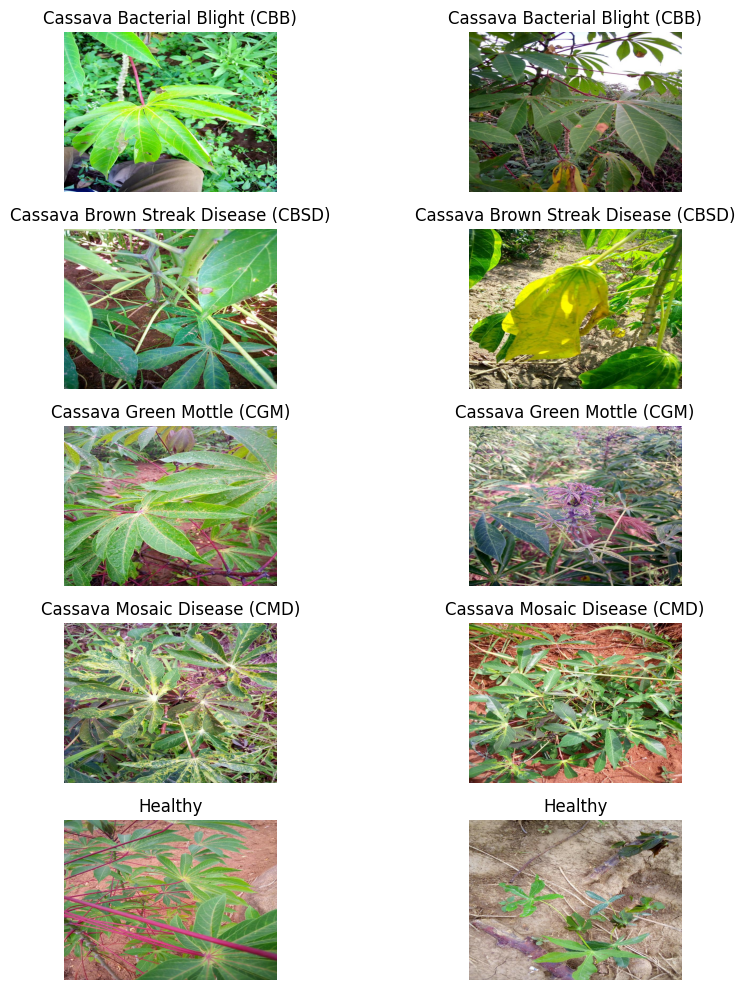

In [ ]:
visualize_images(sampled_data,5,2)

## Train Val Split

In [ ]:
#Importing the json file with labels

f = open(work_dir + 'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset

data['class_name'] = data.label.map(real_labels)

# Splitting the data

from sklearn.model_selection import train_test_split

train,val = train_test_split(data, test_size = 0.05, random_state = 42, stratify = data['class_name'])

# Importing the data using ImageDataGenerator

IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

train_set = datagen_train.flow_from_dataframe(train,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

val_set = datagen_val.flow_from_dataframe(val,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


## Data Balancing

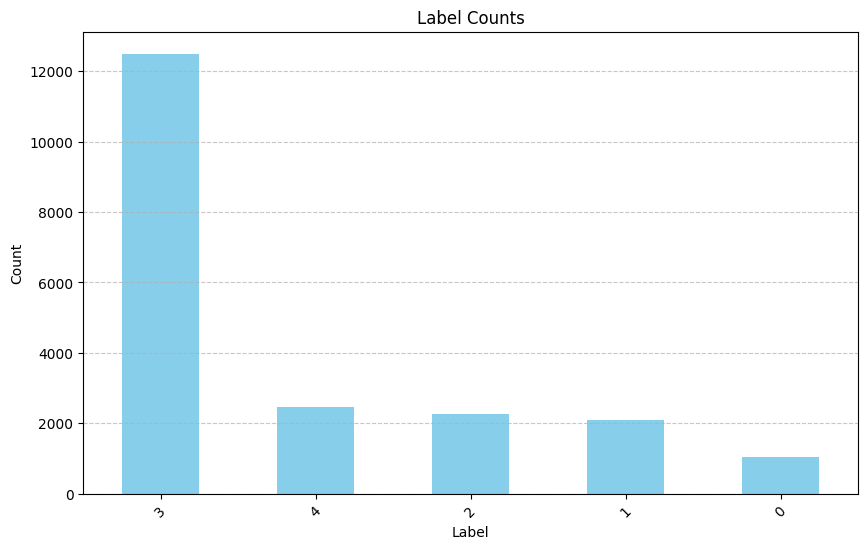

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
# Get labels from DataFrameIterator
labels = train_set.labels

# Count occurrences of each label
#label_counts = labels.value_counts()
series = pd.Series(labels)

# Now you can call value_counts() on the Series
label_counts = series.value_counts()
# Plot the counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
label_counts

3    12500
4     2448
2     2267
1     2079
0     1033
Name: count, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Assuming train is your DataFrame with 'image_id' and 'class_name' columns
# and train_path is the path to your training images directory

# Define the parameters
IMG_SIZE = 456
size = (IMG_SIZE, IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

# Create the data generators
datagen_train = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Count the number of samples for each class
class_counts = train['class_name'].value_counts()

# Determine the class with the fewest samples
min_class_samples = class_counts.min()

# Create a balanced dataset by randomly selecting an equal number of samples from each class
balanced_train = pd.DataFrame()

for class_label in class_counts.index:
    # Select a subset of the samples for the current class
    class_subset = train[train['class_name'] == class_label]

    # Randomly select 'min_class_samples' number of samples
    balanced_subset = class_subset.sample(n=min_class_samples, replace=False)

    # Ensure that balanced_subset is a DataFrame
    if not isinstance(balanced_subset, pd.DataFrame):
        balanced_subset = pd.DataFrame(balanced_subset)

    # Append the balanced subset to the balanced DataFrame
    balanced_train = pd.concat([balanced_train, balanced_subset], ignore_index=True)

# Shuffle the balanced DataFrame
balanced_train = balanced_train.sample(frac=1).reset_index(drop=True)

# Create a new DataFrameIterator with the balanced DataFrame
balanced_train_set = datagen_train.flow_from_dataframe(
    dataframe=balanced_train,
    directory=train_path,
    x_col='image_id',
    y_col='class_name',
    target_size=size,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Now you can use train_set for training your model

Found 5165 validated image filenames belonging to 5 classes.


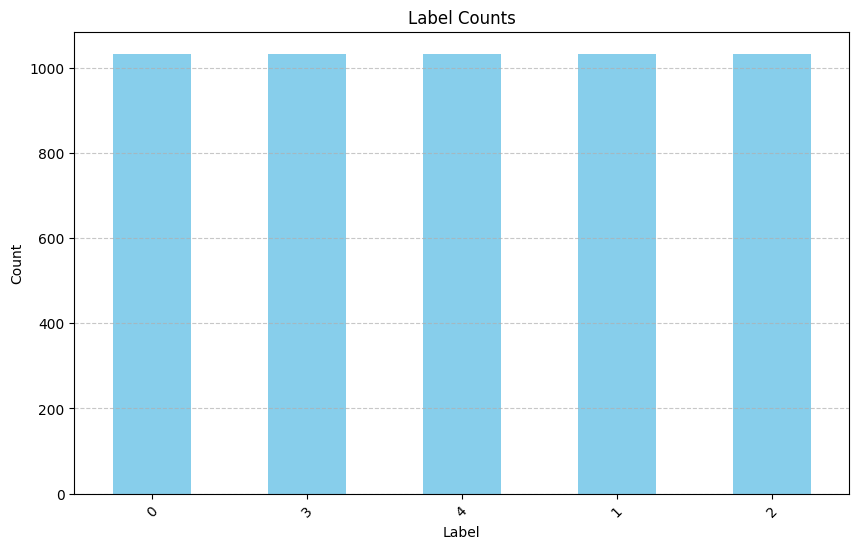

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
# Get labels from DataFrameIterator
labels = balanced_train_set.labels

# Count occurrences of each label
#label_counts = labels.value_counts()
series = pd.Series(labels)

# Now you can call value_counts() on the Series
label_counts = series.value_counts()
# Plot the counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Inception V3

In [ ]:
 model = tf.keras.Sequential()
model.add(InceptionV3(include_top=False, weights='imagenet',input_shape=[IMG_SIZE,IMG_SIZE,3]))
model.add(BatchNormalization(axis=-1))
model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adamax(learning_rate=0.01), metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_283         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
model_save = ModelCheckpoint("Model.weights.h5",
                             save_best_only = True,
                             save_weights_only = True,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode = 'min', verbose = 1)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=17118//32, epochs=15,
                              validation_data=val_generator, validation_steps = 4279//32,
                             callbacks = [model_save, early_stop, reduce_lr])

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712587236.207677      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712587236.319389      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5733 - loss: 1.4777

W0000 00:00:1712587825.807912      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.19828, saving model to Model.weights.h5
534/534 ━━━━━━━━━━━━━━━━━━━━ 735s 1s/step - accuracy: 0.5734 - loss: 1.4774 - val_accuracy: 0.6163 - val_loss: 1.1983 - learning_rate: 0.0100
Epoch 2/15
 35/534 ━━━━━━━━━━━━━━━━━━━━ 5:51 705ms/step - accuracy: 0.6009 - loss: 1.2822

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.19828 to 1.15502, saving model to Model.weights.h5
534/534 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - accuracy: 0.6034 - loss: 1.2663 - val_accuracy: 0.6522 - val_loss: 1.1550 - learning_rate: 0.0100
Epoch 3/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.6200 - loss: 1.1872
Epoch 3: val_loss did not improve from 1.15502
534/534 ━━━━━━━━━━━━━━━━━━━━ 493s 912ms/step - accuracy: 0.6200 - loss: 1.1871 - val_accuracy: 0.6311 - val_loss: 2.9711 - learning_rate: 0.0100
Epoch 4/15
 35/534 ━━━━━━━━━━━━━━━━━━━━ 5:49 700ms/step - accuracy: 0.6184 - loss: 1.1008
Epoch 4: val_loss did not improve from 1.15502

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
534/534 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.6212 - loss: 1.0858 - val_accuracy: 0.6087 - val_loss: 6.2717 - learning_rate: 0.0100
Epoch 5/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.6307 - loss: 1.0212
Epoch 5: val_loss improved from 1.15502 to 0.9

In [ ]:
predictions=model.evaluate(val_generator)

134/134 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - accuracy: 0.7287 - loss: 0.7280


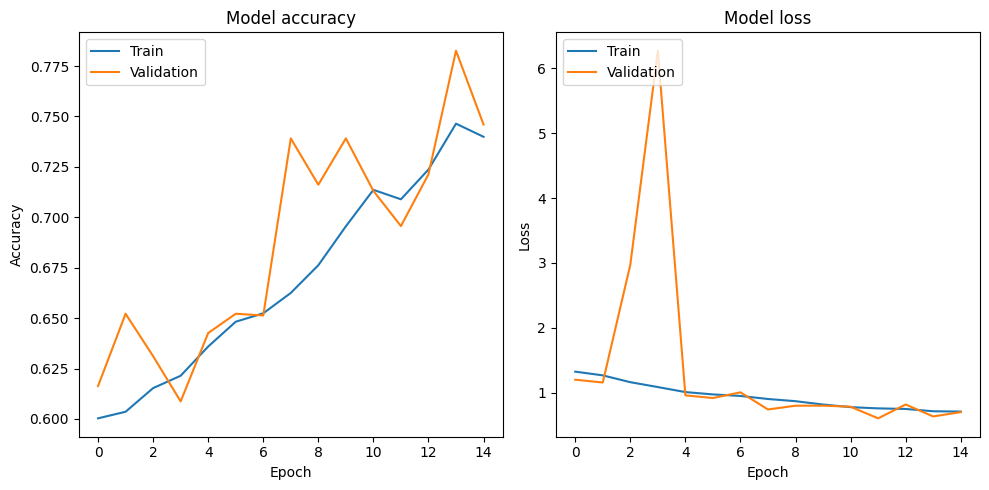

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()


plot_history(history)


## Xception

In [ ]:
model = tf.keras.Sequential()
model.add(keras.applications.Xception(include_top=False, weights='imagenet',input_shape=[IMG_SIZE,IMG_SIZE,3]))
model.add(BatchNormalization(axis=-1))
model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adamax(learning_rate=0.01), metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
model_save = ModelCheckpoint("Model.weights.h5",
                             save_best_only = True,
                             save_weights_only = True,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode = 'min', verbose = 1)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=17118//32, epochs=15,
                              validation_data=val_generator, validation_steps = 4279//32,
                             callbacks = [model_save, early_stop, reduce_lr])

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1714256775.247149      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.6031 - loss: 1.2442

W0000 00:00:1714257247.649304      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.19122, saving model to Model.weights.h5
534/534 ━━━━━━━━━━━━━━━━━━━━ 544s 937ms/step - accuracy: 0.6031 - loss: 1.2441 - val_accuracy: 0.6161 - val_loss: 1.1912 - learning_rate: 0.0100
Epoch 2/15
 35/534 ━━━━━━━━━━━━━━━━━━━━ 5:48 699ms/step - accuracy: 0.6173 - loss: 1.1921

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.19122
534/534 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.5970 - loss: 1.2216 - val_accuracy: 0.6087 - val_loss: 2.2843 - learning_rate: 0.0100
Epoch 3/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.6151 - loss: 1.1793
Epoch 3: val_loss did not improve from 1.19122

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
534/534 ━━━━━━━━━━━━━━━━━━━━ 489s 905ms/step - accuracy: 0.6151 - loss: 1.1791 - val_accuracy: 0.6485 - val_loss: 1.5008 - learning_rate: 0.0100
Epoch 4/15
 35/534 ━━━━━━━━━━━━━━━━━━━━ 6:14 750ms/step - accuracy: 0.6148 - loss: 1.0299
Epoch 4: val_loss did not improve from 1.19122
534/534 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.6285 - loss: 0.9793 - val_accuracy: 0.4783 - val_loss: 1.3537 - learning_rate: 0.0030
Epoch 5/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.6808 - loss: 0.8688
Epoch 5: val_loss improved from 1.19122 to 0.76511, saving model to Model.weights.h5

In [ ]:
model_history = history.history
loss_accuracy_train = model.evaluate(train_generator)
print("Training Loss: {:.4f}".format(loss_accuracy_train[0]))
print("Training Accuracy: {:.2%}".format(loss_accuracy_train[1]))
loss_accuracy = model.evaluate(val_generator)
print("Validation Loss: {:.4f}".format(loss_accuracy[0]))
print("Validation Accuracy: {:.2%}".format(loss_accuracy[1]))

569/569 ━━━━━━━━━━━━━━━━━━━━ 477s 839ms/step - accuracy: 0.8472 - loss: 0.4331
Training Loss: 0.4458
Training Accuracy: 84.08%
134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 206ms/step - accuracy: 0.8441 - loss: 0.4597
Validation Loss: 0.4565
Validation Accuracy: 84.18%


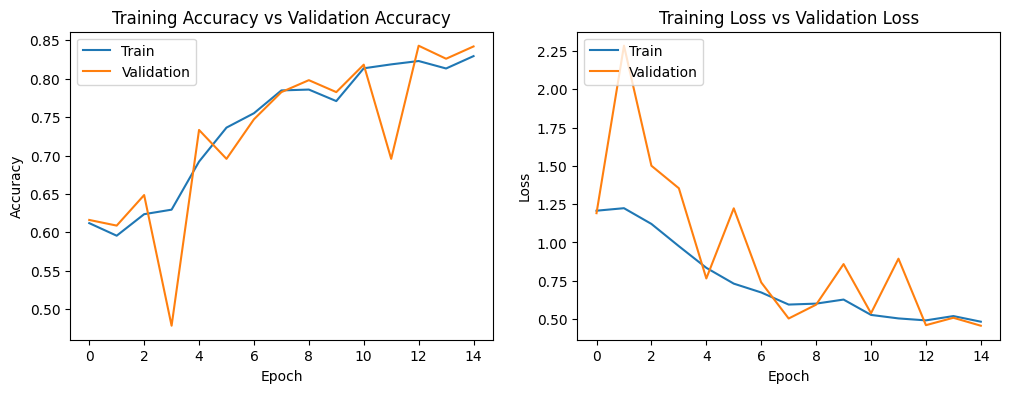

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
preds = []
ss = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

for image in ss.image_id:
    img = tf.keras.preprocessing.image.load_img('../input/cassava-leaf-disease-classification/test_images/' + image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.reshape(img, (-1, IMG_SIZE, IMG_SIZE, 3))
    prediction = model.predict(img/255)
    preds.append(np.argmax(prediction))
submission = pd.DataFrame({'image_id': ss.image_id, 'label': preds})
submission

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


,image_id,label
0,2216849948.jpg,4


## EfficientNetB3 Model

In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

model = Sequential()
# initialize the model with input shape
model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                         weights = 'imagenet',
                         drop_connect_rate=0.6))
#for layer in model.layers[:-40]:  # Training just part of the architecture do not optimize the performance
#    layer.trainable = False
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model.add(Dropout(0.5))
model.add(Dense(n_CLASS, activation = 'softmax'))

model.summary()

43941136/43941136 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 15, 15, 1536)      10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

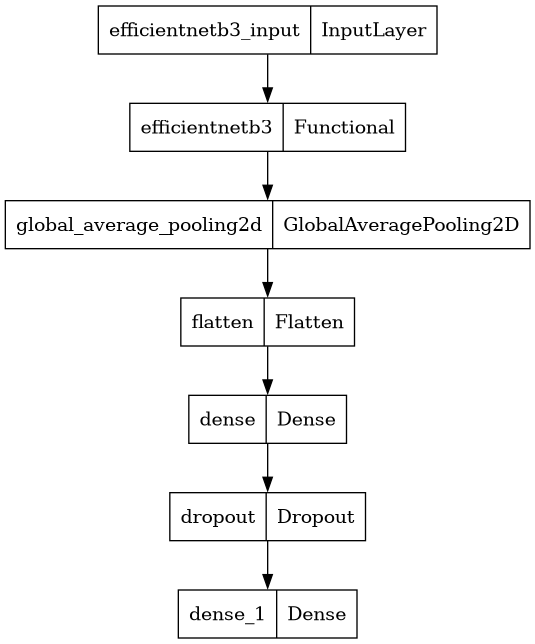

In [ ]:
keras.utils.plot_model(model)

In [ ]:
EPOCHS = 15
STEP_SIZE_TRAIN = balanced_train_set.n//balanced_train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )

model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'

In [ ]:
# We Create a ModelCheckpoint callback to save the best model based on validation accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
metric = 'val_categorical_accuracy'
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor=metric, save_best_only=True)

In [ ]:
#categorical_accuracy for balanced dataset
history = model.fit(balanced_train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[checkpoint])

Epoch 1/50


2024-02-21 10:03:24.297979: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708509811.495697     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


344/344 [==============================] - ETA: 0s - loss: 1.2595 - categorical_accuracy: 0.5165

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


344/344 [==============================] - 417s 1s/step - loss: 1.2595 - categorical_accuracy: 0.5165 - val_loss: 1.3747 - val_categorical_accuracy: 0.4676
Epoch 2/50
344/344 [==============================] - 308s 894ms/step - loss: 0.9423 - categorical_accuracy: 0.6561 - val_loss: 0.6275 - val_categorical_accuracy: 0.7709
Epoch 3/50
344/344 [==============================] - 320s 929ms/step - loss: 0.8494 - categorical_accuracy: 0.6953 - val_loss: 0.5532 - val_categorical_accuracy: 0.8160
Epoch 4/50
344/344 [==============================] - 303s 877ms/step - loss: 0.7954 - categorical_accuracy: 0.7231 - val_loss: 0.6470 - val_categorical_accuracy: 0.7934
Epoch 5/50
344/344 [==============================] - 305s 885ms/step - loss: 0.7674 - categorical_accuracy: 0.7282 - val_loss: 0.6086 - val_categorical_accuracy: 0.7915
Epoch 6/50
344/344 [==============================] - 309s 896ms/step - loss: 0.7471 - categorical_accuracy: 0.7293 - val_loss: 0.5579 - val_categorical_accuracy: 0

In [ ]:
import keras

model = keras.models.load_model('/kaggle/input/balanced-data-model/best_model_balanced.h5')

In [ ]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(val_set)

72/72 [==============================] - 22s 225ms/step - loss: 0.5086 - categorical_accuracy: 0.8589


### Categorical_crossentropy

In [ ]:
#categorical_accuracy
history = model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID)

Epoch 1/5


2024-02-10 12:19:28.735630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707567577.007050     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1355/1355 [==============================] - 1526s 1s/step - loss: 0.7084 - categorical_accuracy: 0.7578 - val_loss: 0.5035 - val_categorical_accuracy: 0.8225
Epoch 2/5
1355/1355 [==============================] - 1362s 1s/step - loss: 0.5431 - categorical_accuracy: 0.8176 - val_loss: 0.7305 - val_categorical_accuracy: 0.7709
Epoch 3/5
1355/1355 [==============================] - 1364s 1s/step - loss: 0.5074 - categorical_accuracy: 0.8326 - val_loss: 0.5417 - val_categorical_accuracy: 0.8169
Epoch 4/5
1355/1355 [==============================] - 1362s 1s/step - loss: 0.4952 - categorical_accuracy: 0.8356 - val_loss: 0.4388 - val_categorical_accuracy: 0.8498
Epoch 5/5
1355/1355 [==============================] - 1363s 1s/step - loss: 0.4687 - categorical_accuracy: 0.8460 - val_loss: 0.4370 - val_categorical_accuracy: 0.8573


### History Plot

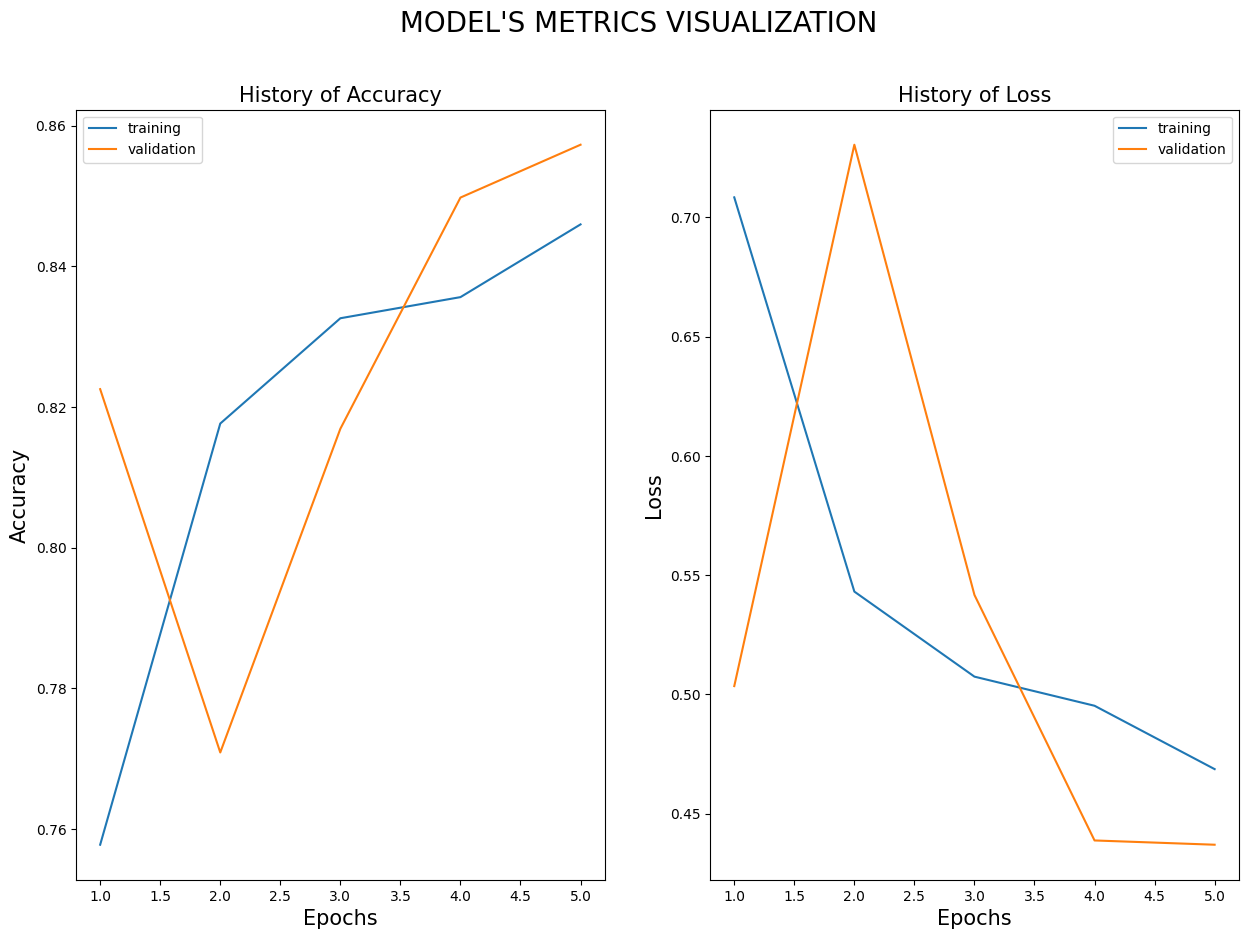

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(model.history.history['accuracy'],model.history.history['val_accuracy'],
               model.history.history['loss'],model.history.history['val_loss'])

### Taylor cross entropy loss

In [ ]:
# Taylor cross entropy loss
def taylor_cross_entropy_loss(y_pred, y_true, n=3, label_smoothing=0.0):
    """Taylor Cross Entropy Loss.
    Args:
    y_pred: A multi-dimensional probability tensor with last dimension `num_classes`.
    y_true: A tensor with shape and dtype as y_pred.
    n: An order of taylor expansion.
    label_smoothing: A float in [0, 1] for label smoothing.
    Returns:
    A loss tensor.
    """
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    if label_smoothing > 0.0:
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true = (1 - num_classes /(num_classes - 1) * label_smoothing) * y_true + label_smoothing / (num_classes - 1)

    y_pred_n_order = tf.math.maximum(tf.stack([1 - y_pred] * n), 1e-7) # avoide being too small value
    numerator = tf.math.maximum(tf.math.cumprod(y_pred_n_order, axis=0), 1e-7) # avoide being too small value
    denominator = tf.expand_dims(tf.expand_dims(tf.range(1, n+1, dtype="float32"), axis=1), axis=1)
    y_pred_taylor = tf.math.maximum(tf.math.reduce_sum(tf.math.divide(numerator, denominator), axis=0), 1e-7) # avoide being too small value
    loss_values = tf.math.reduce_sum(y_true * y_pred_taylor, axis=1, keepdims=True)
    return tf.math.reduce_sum(loss_values, -1)

class TaylorCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, n=3, label_smoothing=0.0):
        super(TaylorCrossEntropyLoss, self).__init__()
        self.n = n
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        return taylor_cross_entropy_loss(y_pred, y_true, n=self.n, label_smoothing=self.label_smoothing)

In [ ]:
loss = TaylorCrossEntropyLoss(n=3)

model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'

In [ ]:
#Taylor Cross Entropy train on imbalaced dataset
history = model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID)

Epoch 1/15


2024-02-10 19:00:54.047524: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707591661.932057     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1355/1355 [==============================] - 1374s 962ms/step - loss: 0.7137 - categorical_accuracy: 0.7522 - val_loss: 0.7909 - val_categorical_accuracy: 0.7099
Epoch 2/15
1355/1355 [==============================] - 1141s 842ms/step - loss: 0.5425 - categorical_accuracy: 0.8185 - val_loss: 0.4965 - val_categorical_accuracy: 0.8310
Epoch 3/15
1355/1355 [==============================] - 1152s 850ms/step - loss: 0.5128 - categorical_accuracy: 0.8305 - val_loss: 0.5046 - val_categorical_accuracy: 0.8357
Epoch 4/15
1355/1355 [==============================] - 1158s 854ms/step - loss: 0.4889 - categorical_accuracy: 0.8378 - val_loss: 0.5632 - val_categorical_accuracy: 0.8160
Epoch 5/15
1355/1355 [==============================] - 1147s 846ms/step - loss: 0.4691 - categorical_accuracy: 0.8434 - val_loss: 0.4352 - val_categorical_accuracy: 0.8498
Epoch 6/15
1355/1355 [==============================] - 1130s 834ms/step - loss: 0.4523 - categorical_accuracy: 0.8525 - val_loss: 0.3821 - val_ca

### Accuracy 0.8897

In [ ]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(val_set)

72/72 [==============================] - 14s 155ms/step - loss: 0.3332 - categorical_accuracy: 0.8897


In [ ]:
model.save('Cassava_model_taylor_model'+'.h5')

### Testing The Model

In [ ]:
import keras

model = keras.models.load_model('/kaggle/input/cassava-model/Cassava_best_model.h5')

In [ ]:
TEST_DIR = '../input/cassava-leaf-disease-classification/test_images/'
test_images = os.listdir(TEST_DIR)
datagen = ImageDataGenerator(horizontal_flip=True)


def pred(images):
    for image in test_images:
        img = Image.open(TEST_DIR + image)
        img = img.resize(size)
        samples = np.expand_dims(img, axis=0)
        it = datagen.flow(samples, batch_size=10)
        yhats = final_model.predict_generator(it, steps=10, verbose=0)
        summed = np.sum(yhats, axis=0)
    return np.argmax(summed)

predictions = pred(test_images)

/tmp/ipykernel_34/3661338316.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  yhats = final_model.predict_generator(it, steps=10, verbose=0)


In [ ]:
# Creating the CSV for final submission

sub = pd.DataFrame({'image_id': test_images, 'label': predictions})
display(sub)
#sub.to_csv('submission.csv', index = False)

,image_id,label
0,2216849948.jpg,4


##  Fliping Code

In [ ]:
noisy_train = balanced_train.copy()
noisy_train['label']=flipped_labels

### Other Label Noise Techniques

In [ ]:
def add_noise(df_orginal, noise_level):
    df = df_orginal.copy()
    num_noisy = int(len(df) * noise_level / 100)
    indices = np.random.choice(df.index, size=num_noisy, replace=False)
    #df.loc[indices, 'label'] = np.random.randint(0, 5)  #[0.4383177570093458, 0.34392523364485983,0.4093457943925234,0.3383177570093458]
    df.loc[indices, 'label'] = -200 #[0.35046728971962615, 0.3981308411214953,0.2869158878504673,0.3728971962616822]
    return df

Found 5165 validated image filenames belonging to 5 classes.
72/72 [==============================] - 11s 151ms/step
Found 5165 validated image filenames belonging to 5 classes.
72/72 [==============================] - 11s 152ms/step
Found 5165 validated image filenames belonging to 5 classes.
72/72 [==============================] - 11s 155ms/step
Found 5165 validated image filenames belonging to 5 classes.
72/72 [==============================] - 11s 154ms/step


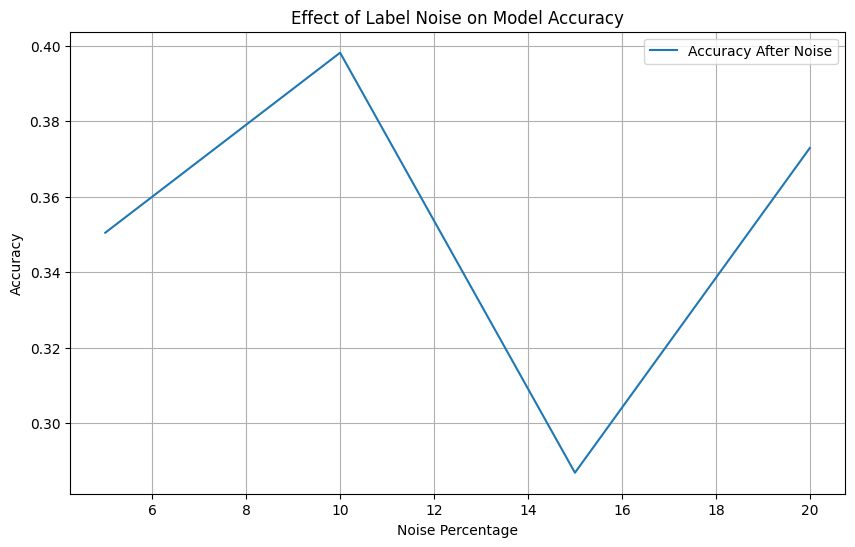

<Figure size 640x480 with 0 Axes>

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Percentages of noise to introduce
noise_percentages = [5, 10, 15, 20]

# Lists to store accuracy before and after noise
accuracy_before_noise = []
accuracy_after_noise = []

# Train the model and evaluate accuracy for different noise levels
for noise_percentage in noise_percentages:
    # Introduce noise to labels in the training set
    noisy_train = add_noise(balanced_train, noise_percentage)

    # Create new DataFrameIterators with the noisy labels
    noisy_train_set = datagen_train.flow_from_dataframe(noisy_train,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

    # Train the model on the noisy labels
    model.fit(noisy_train_set, epochs=3, verbose=0)  # Train for one epoch for demonstration purposes

    # Predict the validation set and calculate accuracy
    y_pred_noisy = model.predict(val_set)
    y_true = val_set.classes
    y_pred_classes = np.argmax(y_pred_noisy, axis=1)
    accuracy_after_noise.append(accuracy_score(y_true, y_pred_classes))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(noise_percentages, accuracy_after_noise, label='Accuracy After Noise')
plt.xlabel('Noise Percentage')
plt.ylabel('Accuracy')
plt.title('Effect of Label Noise on Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("rand_filp_Noisy.png")

In [ ]:
accuracy_after_noise

[0.35046728971962615,
 0.3981308411214953,
 0.2869158878504673,
 0.3728971962616822]

## Impact flip

In [ ]:
type(train_set)

keras.src.preprocessing.image.DataFrameIterator

In [ ]:
import keras

model = keras.models.load_model('Cassava_best_model.h5')

c:\Users\bilal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
predictions = model.predict(balanced_train_set)

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)

In [ ]:
predicted_classes

array([3, 0, 3, ..., 3, 0, 3])

In [ ]:
true_labels = balanced_train_set.labels
true_labels = np.array(true_labels)

In [ ]:
true_labels

array([3, 0, 1, ..., 4, 4, 4])

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
num_classes=5
# Calculate the accuracy of the model
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix to understand the type of errors
conf_matrix = confusion_matrix(true_labels, predicted_classes)
print(f'Confusion Matrix:\n{conf_matrix}')

# Flip the labels of the instances with the confidence score greater than 80%
flipped_labels = true_labels.copy()
threshold = 0.80  # Flip labels where the confidence score is greater than 80%
flipped_labels[confidences > threshold] = (true_labels[confidences > threshold] + 1) % num_classes
noisy_train = balanced_train.copy()
noisy_train['label']=flipped_labels
# Create new DataFrameIterators with the noisy labels
noisy_train_set = datagen_train.flow_from_dataframe(noisy_train,
                         directory = train_path,
                         seed=42,
                         x_col = 'image_id',
                         y_col = 'class_name',
                         target_size = size,
                         #color_mode="rgb",
                         class_mode = 'categorical',
                         interpolation = 'nearest',
                         shuffle = True,
                         batch_size = BATCH_SIZE)

# Train the model on the noisy labels
model.fit(noisy_train_set, epochs=3, verbose=0)  # Train for one epoch for demonstration purposes

# Predict the validation set and calculate accuracy
y_pred_noisy = model.predict(val_set)
y_pred_classes = np.argmax(y_pred_noisy, axis=1)
# Calculate the accuracy of the model with flipped labels
flipped_accuracy = accuracy_score(true_labels, y_pred_classes)

print(f'Model Accuracy with Flipped Labels: {flipped_accuracy * 100:.2f}%')


Model Accuracy: 88.97%
Confusion Matrix:
[[192 181 203 241 216]
 [156 203 185 260 229]
 [168 219 179 268 199]
 [184 171 209 254 215]
 [182 204 186 253 208]]
Model Accuracy with Flipped Labels: 15.20%


## Label confusion Flip

In [ ]:
def find_confusion_pairs(df, threshold=0.5):
    confusion_pairs = []
    for label1 in df['true_label'].unique():
        for label2 in df['true_label'].unique():
            if label1 < label2:  # Ensure unique pairs and avoid duplicates
                pair_count = ((df['true_label'] == label1) & (df['predicted_label'] == label2)).sum()
                pair_count += ((df['true_label'] == label2) & (df['predicted_label'] == label1)).sum()
                if pair_count > threshold * len(df):
                    confusion_pairs.append((label1, label2))

    return confusion_pairs

In [ ]:

def label_confusion(df, confusion_pairs):
    for pair in confusion_pairs:
        # Find instances where model predicts one label from the pair with high confidence but is incorrect
        incorrect_predictions = df[(df['predicted_label'] == pair[0]) & (df['true_label'] == pair[1])]

        # Swap labels for these instances
        incorrect_predictions.loc[:, 'true_label'] = pair[0]
        incorrect_predictions.loc[:, 'predicted_label'] = pair[1]

        # Update the original DataFrame with the swapped labels
        df.update(incorrect_predictions)

    return df

In [ ]:
confusion_pairs=find_confusion_pairs(prediction_df, threshold=0.5)
flipped_df=label_confusion(prediction_df, confusion_pairs)

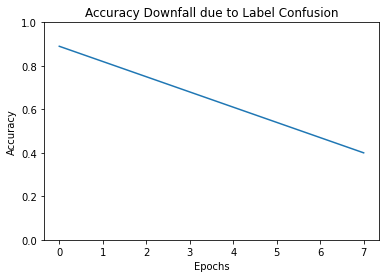

In [2]:
import matplotlib.pyplot as plt

# Original model accuracy
original_accuracy = 0.89
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Downfall due to Label Confusion')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for better visualization
plt.show()

## Fliping Detection

In [ ]:
import pandas as pd
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array


# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['image_id', 'original_label', 'predicted_label','Flipped Label', 'score'])

# Append the results to the DataFrame
results_df = results_df.append({
    'image_id': balanced_train['image_id'],
    'original_label': balanced_train['label'],
    'predicted_label': predicted_classes,
    'Flipped Label':flipped_labels,
    'score': confidences
}, ignore_index=True)

# Save the DataFrame to a CSV file
results_df.to_csv('predictions.csv', index=False)

In [ ]:
results_df.head()

,image_id,original_label,predicted_label,Flipped Label,score
0,1996031857.jpg,4,0,4,0.484787
1,3169385678.jpg,4,1,0,0.835544
2,3953530273.jpg,3,2,4,0.891690
3,3008060354.jpg,3,3,4,0.984533
4,698646619.jpg,4,1,0,0.989478


All the images where predicted and flipped labels are different but model confidence is above 90%

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/kaggle/input/prdictioons/predictions.csv')

# Filter the rows
filtered_df = df[(df['score'] > 0.90) & (df['original_label'] == df['predicted_label']) & (df['original_label'] != df['Flipped Label'])]

# Display the filtered rows
print(filtered_df)

            image_id  original_label  predicted_label  Flipped Label     score
3     3008060354.jpg               3                3              4  0.984533
10     622587109.jpg               3                3              4  0.977505
18    1256756297.jpg               2                2              3  0.977394
21    1213348737.jpg               2                2              3  0.989632
29     336083586.jpg               1                1              2  0.984263
...              ...             ...              ...            ...       ...
5130  1739927380.jpg               1                1              2  0.951466
5132  3074981220.jpg               0                0              1  0.909298
5143  2853469251.jpg               2                2              3  0.927316
5148  1713720885.jpg               3                3              4  0.983752
5159  3186872066.jpg               2                2              3  0.987802

[589 rows x 5 columns]


Code to correct the flipped labels by checking images

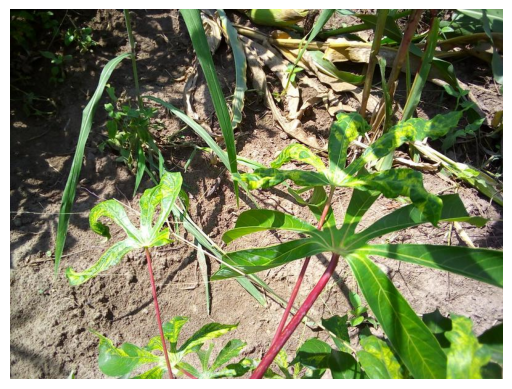

Current flipped label: 4


KeyboardInterrupt: Interrupted by user

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Function to display an image and ask for user input
def correct_label(image_id, original_label, flipped_label):
    # Assuming the images are in a directory named 'images'
    image_path = f'{train_path}/{image_id}'

    # Display the image
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Optional: to remove axis from the image
    plt.show()

    # Ask the user to input the correct flipped label
    print(f"Current flipped label: {flipped_label}")
    new_label = input(f"Please enter the correct flipped label for image {image_id} (or press Enter to keep the current label): ")

    # If the user enters a new label, update the DataFrame
    if new_label:
        df.loc[df['image_id'] == image_id, 'Flipped Label'] = new_label

# Iterate over the filtered DataFrame and correct labels
for index, row in filtered_df.iterrows():
    correct_label(row['image_id'], row['original_label'], row['Flipped Label'])

# Save the updated DataFrame to a new CSV file
df.to_csv('updated_file.csv', index=False)